## Libraries

In [2]:
import os
import requests
from tqdm import tqdm
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
import cv2
import geopandas as gpd
from shapely.geometry import box
import pandas as pd


# Define the URLs provided in the image
granule = "40S_080W"

output_dir = "./data/chile_gfc_data"
os.makedirs(output_dir, exist_ok=True)

## Downloading Hansen Deforestation Dataset

In [ ]:
base_url = "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2024-v1.12/"

files_to_download = [
    f"Hansen_GFC-2024-v1.12_treecover2000_{granule}.tif",
    f"Hansen_GFC-2024-v1.12_lossyear_{granule}.tif",
    f"Hansen_GFC-2024-v1.12_gain_{granule}.tif",
    f"Hansen_GFC-2024-v1.12_datamask_{granule}.tif"
    
]

def     download_file(url, filepath):
    """Resumable, progress-bar enabled download."""
    response = requests.get(url, stream=True)
    total_size_in_bytes = int(response.headers.get('content-length', 0))
    block_size = 1024 * 1024    

    if os.path.exists(filepath) and os.path.getsize(filepath) == total_size_in_bytes:
        print(f"{filepath} already exists and is complete. Skipping.")
        return

    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(filepath, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()

In [ ]:
print("Starting downloads...")
local_paths = {}
for file_name in files_to_download:
    url = base_url + file_name
    local_path = os.path.join(output_dir, file_name)
    print(f"Processing: {file_name}")
    download_file(url, local_path)

    key = file_name.split('_')[3] 
    local_paths[key] = local_path
print("Downloads complete.")

## Map of the Area of Interest 

/tmp/ipykernel_1720674/2323530842.py:52: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right')
/tmp/ipykernel_1720674/2323530842.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


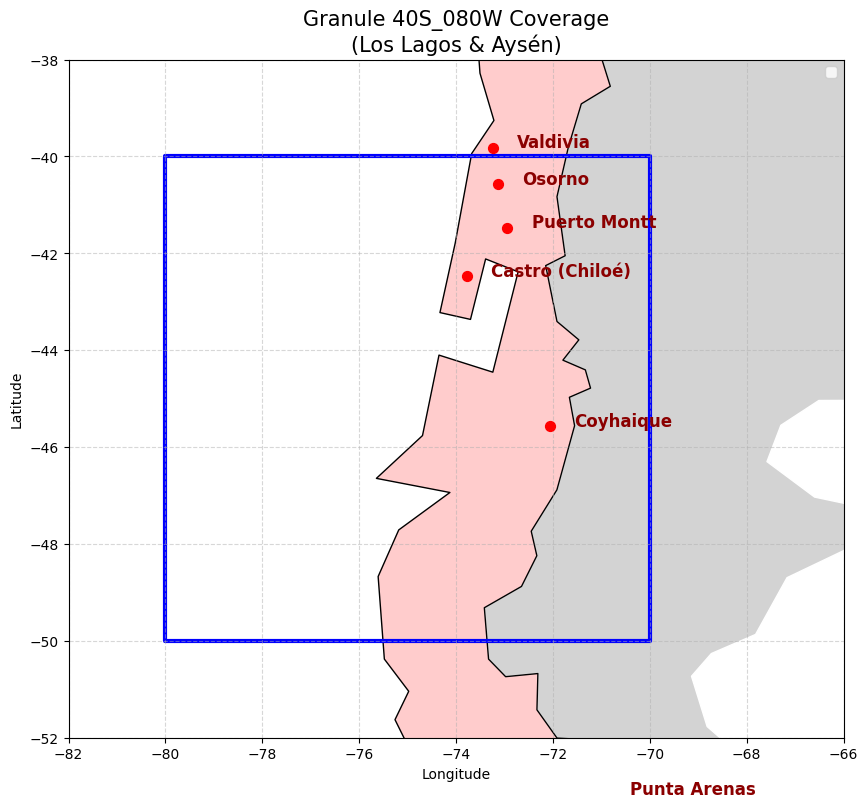

In [ ]:



world_url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json"
world = gpd.read_file(world_url)

minx, miny, maxx, maxy = -80, -50, -70, -40
granule_box = box(minx, miny, maxx, maxy)


chile = world[world.name == "Chile"]
argentina = world[world.name == "Argentina"]


cities_data = {
    'City': ['Valdivia', 'Osorno', 'Puerto Montt', 'Castro (Chiloé)', 'Coyhaique', 'Punta Arenas'],
    'Lat': [-39.8196, -40.5739, -41.4689, -42.4721, -45.5712, -53.1638],
    'Lon': [-73.2452, -73.1335, -72.9411, -73.7732, -72.0685, -70.9171]
}
cities_df = pd.DataFrame(cities_data)
cities_gdf = gpd.GeoDataFrame(cities_df, geometry=gpd.points_from_xy(cities_df.Lon, cities_df.Lat))


fig, ax = plt.subplots(figsize=(10, 12))


world[world.name == 'Argentina'].plot(ax=ax, color='lightgrey', edgecolor='white') 
chile.plot(ax=ax, color='#ffcccc', edgecolor='black')


gpd.GeoSeries([granule_box]).plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=3, label='Granule 40S_080W')


cities_gdf.plot(ax=ax, color='red', markersize=50, zorder=5)


for x, y, label in zip(cities_df.Lon, cities_df.Lat, cities_df.City):

    if -55 <= y <= -38: 
        ax.text(x + 0.5, y, label, fontsize=12, color='darkred', weight='bold')

ax.set_xlim(-82, -66)
ax.set_ylim(-52, -38)

ax.set_title("Granule 40S_080W Coverage\n(Los Lagos & Aysén)", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right')

plt.show()

## Defining Path

In [3]:
datamask_path = "/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/data/chile_gfc_data/Hansen_GFC-2024-v1.12_datamask_40S_080W.tif"
treecover2000_path = "/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/data/chile_gfc_data/Hansen_GFC-2024-v1.12_treecover2000_40S_080W.tif"
lossyear_path = "/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/data/chile_gfc_data/Hansen_GFC-2024-v1.12_lossyear_40S_080W.tif"   
gain_path = "/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/data/chile_gfc_data/Hansen_GFC-2024-v1.12_gain_40S_080W.tif"     


## Loading complete masks 

In [ ]:

with rasterio.open(datamask_path) as src_mask:

    datamask_img = src_mask.read(1)
    land_mask = (datamask_img == 1)
    profile = src_mask.profile
    transform = src_mask.transform


with rasterio.open(treecover2000_path) as src_tc:
    tc2000_img = src_tc.read(1)
    tc2000_masked = np.where(land_mask, tc2000_img, 0)

with rasterio.open(lossyear_path) as src_ly:
    lossyear_img = src_ly.read(1)
    lossyear_masked = np.where(land_mask, lossyear_img, 0)

In [ ]:
print(f"Data shape: {lossyear_masked.shape}")
print(f"CRS: {profile['crs']}")
print(f"Loss year range (masked): {lossyear_masked.min()} - {lossyear_masked.max()}")

Data shape: (40000, 40000)
CRS: EPSG:4326
Loss year range (masked): 0 - 24


## Pixel loss per year

In [6]:
years, counts = np.unique(lossyear_masked[lossyear_masked > 0], return_counts=True)

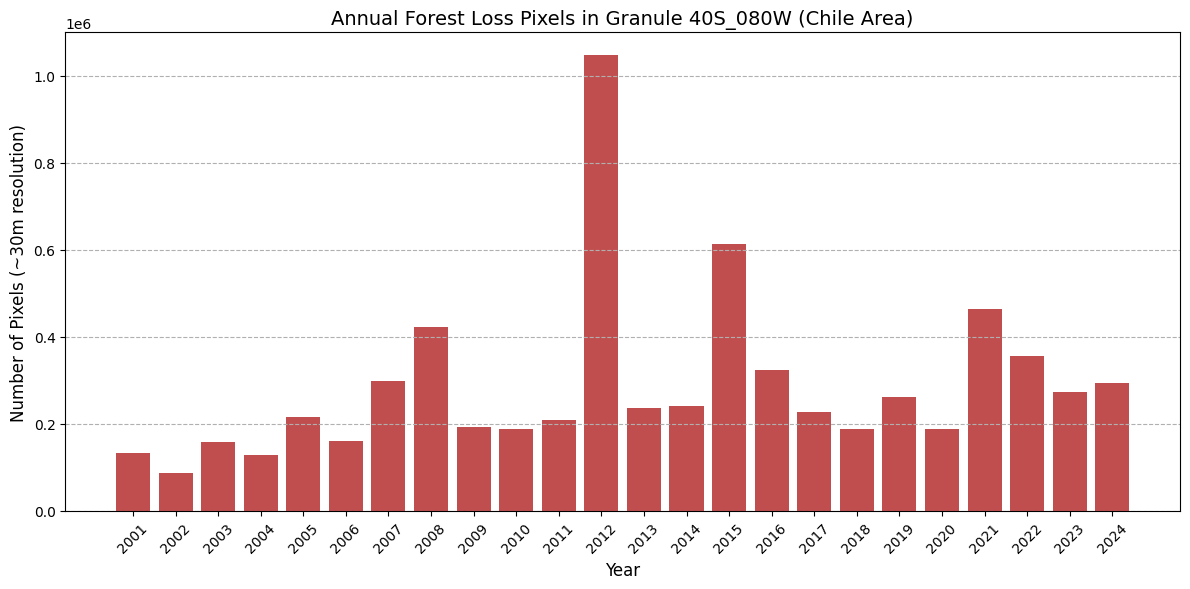

Peak deforestation year in this granule occurred in: 2012


In [ ]:


actual_years = np.int32(years) + 2000

plt.figure(figsize=(12, 6))
plt.bar(actual_years, counts, color='firebrick', alpha=0.8)
plt.title(f"Annual Forest Loss Pixels in Granule {granule} (Chile Area)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Pixels (~30m resolution)", fontsize=12)
plt.xticks(actual_years, rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

peak_year_idx = np.argmax(counts)
print(f"Peak deforestation year in this granule occurred in: {actual_years[peak_year_idx]}")

## Loading deciminated mask for more efficient masking 

In [ ]:

decimation_factor = 10 

print("Loading data with smart decimation to prevent RAM crash...")

with rasterio.open(lossyear_path) as src:
    new_height = src.height // decimation_factor
    new_width = src.width // decimation_factor
    
    lossyear_small = src.read(
        1,
        out_shape=(new_height, new_width),
        resampling=rasterio.enums.Resampling.nearest
    )

with rasterio.open(treecover2000_path) as src:
    tc2000_small = src.read(
        1,
        out_shape=(new_height, new_width),
        resampling=rasterio.enums.Resampling.nearest
    )

with rasterio.open(datamask_path) as src:
    datamask_small = src.read(
        1,
        out_shape=(new_height, new_width),
        resampling=rasterio.enums.Resampling.nearest
    )

print(f"Data successfully loaded. New shape: {lossyear_small.shape}")

Loading data with smart decimation to prevent RAM crash...
Data successfully loaded. New shape: (4000, 4000)


Generating plot...


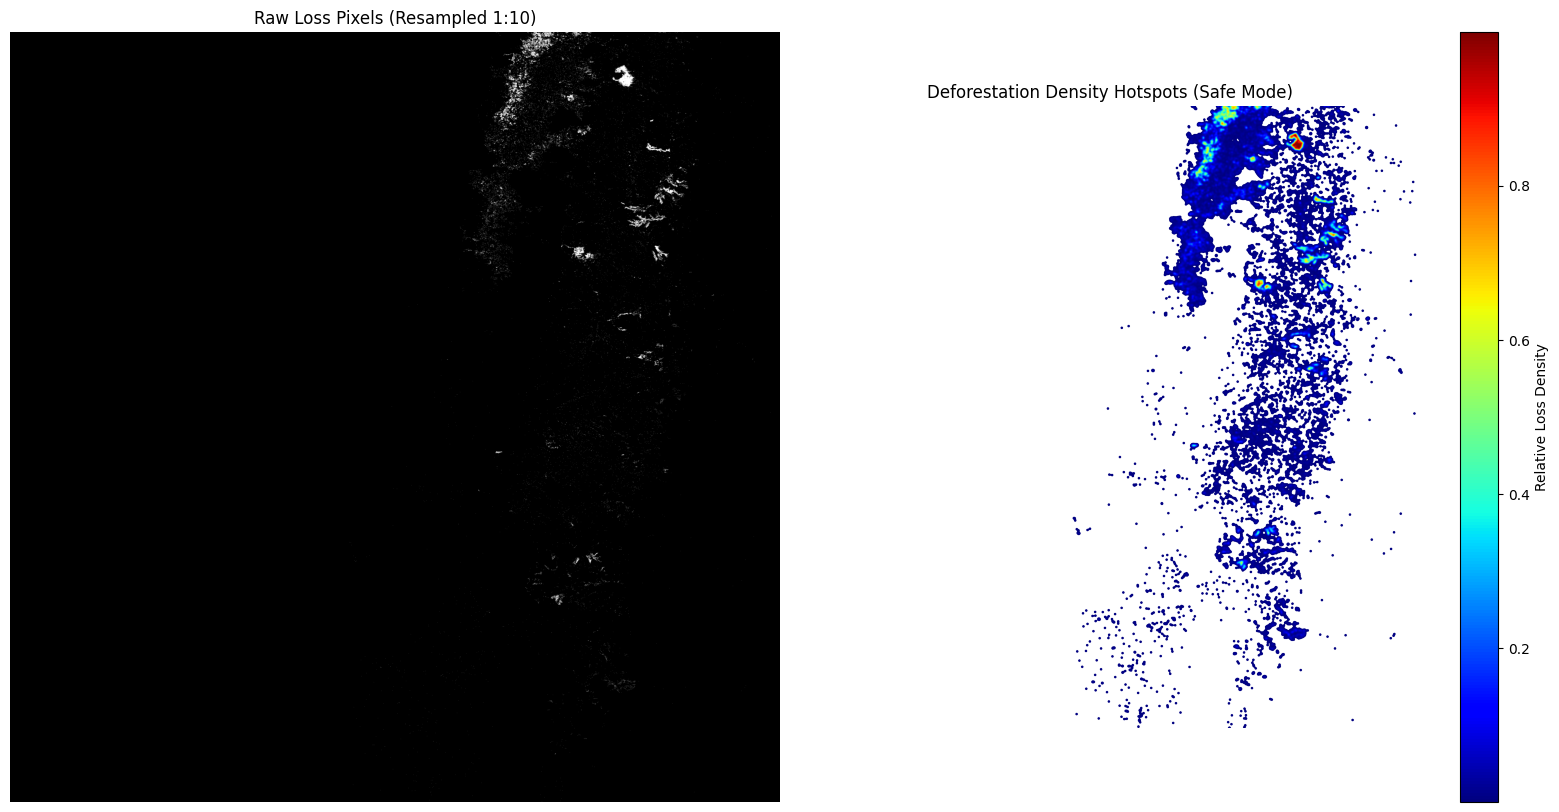

In [ ]:

land_mask_small = (datamask_small == 1)
forest_baseline_mask_small = (tc2000_small > 30)

cumulative_loss_small = (
    (lossyear_small > 0) & 
    forest_baseline_mask_small & 
    land_mask_small
).astype(np.float32) 

sigma_adjusted = 5 
loss_density_heatmap = gaussian_filter(cumulative_loss_small, sigma=sigma_adjusted)

print("Generating plot...")
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(cumulative_loss_small, cmap='gray', vmin=0, vmax=1)
ax[0].set_title(f"Raw Loss Pixels (Resampled 1:{decimation_factor})")
ax[0].axis('off')

cmap_heat = plt.cm.jet
cmap_heat.set_under('white', alpha=0) 

im = ax[1].imshow(loss_density_heatmap, cmap=cmap_heat, vmin=0.001)
ax[1].set_title("Deforestation Density Hotspots (Safe Mode)")
ax[1].axis('off')
plt.colorbar(im, ax=ax[1], label="Relative Loss Density")

plt.tight_layout()
plt.show()

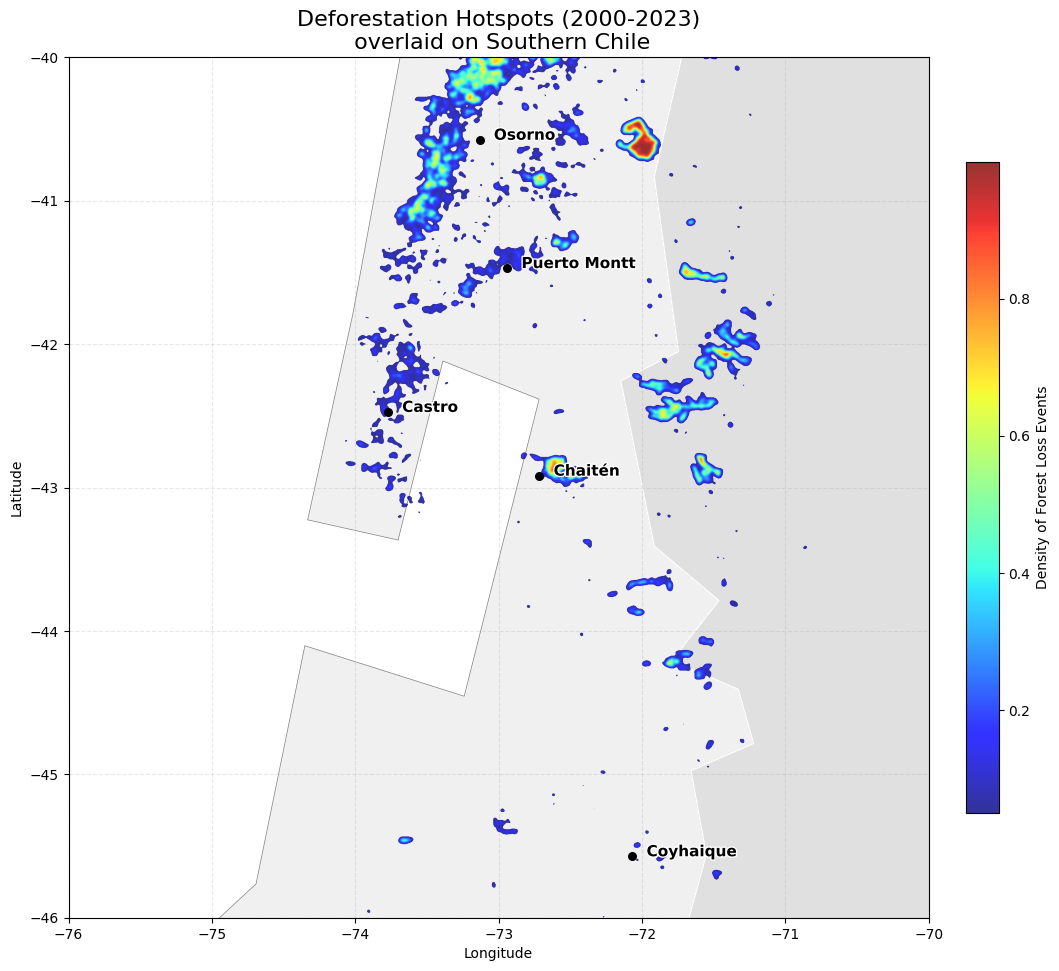

In [ ]:
import matplotlib.patheffects as pe

world_url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json"
world = gpd.read_file(world_url)
chile = world[world.name == "Chile"]

heatmap_overlay = np.ma.masked_where(loss_density_heatmap < 0.05, loss_density_heatmap)

granule_extent = [-80, -70, -50, -40]

fig, ax = plt.subplots(figsize=(12, 12))


chile.plot(ax=ax, color='#f0f0f0', edgecolor='grey', linewidth=0.5, zorder=1)
world[world.name == "Argentina"].plot(ax=ax, color='#e0e0e0', edgecolor='white', zorder=1)


cmap_heat = plt.cm.jet
cmap_heat.set_bad('white', alpha=0)

im = ax.imshow(
    heatmap_overlay, 
    cmap=cmap_heat, 
    extent=granule_extent, 
    origin='upper', 
    alpha=0.8, 
    zorder=2
)

cities_data = {
    'City': ['Valdivia', 'Osorno', 'Puerto Montt', 'Castro', 'Chaitén', 'Coyhaique'],
    'Lat': [-39.8196, -40.5739, -41.4689, -42.4721, -42.9167, -45.5712],
    'Lon': [-73.2452, -73.1335, -72.9411, -73.7732, -72.7167, -72.0685]
}
cities_df = gpd.GeoDataFrame(
    cities_data, 
    geometry=gpd.points_from_xy(cities_data['Lon'], cities_data['Lat'])
)

cities_df.plot(ax=ax, color='black', markersize=30, zorder=3)

for x, y, label in zip(cities_data['Lon'], cities_data['Lat'], cities_data['City']):
    if -50 <= y <= -40: # Only plot label if inside our view
        ax.text(x + 0.1, y, label, fontsize=11, color='black', weight='bold', zorder=4, 
                path_effects=[pe.withStroke(linewidth=2, foreground="white")])

ax.set_title("Deforestation Hotspots (2000-2023)\n overlaid on Southern Chile", fontsize=16)
ax.set_xlim(-76, -70) 
ax.set_ylim(-46, -40) 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle='--', alpha=0.3)


cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
cbar.set_label("Density of Forest Loss Events")

plt.show()

In [ ]:
import rasterio
import numpy as np
import cv2
import os
from tqdm import tqdm


DENSITY_THRESHOLD = 0.05  
BLOCK_SIZE = 2048          
mask_output_path = os.path.join(output_dir, f"{granule}_filtered_segmentation_mask_hard_2.tif")


print("1. Preparing Hotspot Mask...")

hotspot_mask_small = (loss_density_heatmap > DENSITY_THRESHOLD).astype(np.uint8)

with rasterio.open(lossyear_path) as src:
    H, W = src.height, src.width
    profile = src.profile.copy()

hotspot_mask_full = cv2.resize(
    hotspot_mask_small, 
    (W, H), 
    interpolation=cv2.INTER_NEAREST
)
print(f"   Hotspot mask ready: {hotspot_mask_full.shape}")

1. Preparing Hotspot Mask...
   Hotspot mask ready: (40000, 40000)


In [ ]:
RECENCY_THRESHOLD_YEAR =17

profile.update({
    'dtype': rasterio.uint8,
    'count': 1,
    'nodata': 0,
    'driver': 'GTiff',
    'compress': 'lzw',
    'tiled': True,       
    'blockxsize': 256,
    'blockysize': 256
})

print("2. Starting Block Processing (Memory Safe Mode)...")

# Open all input files in 'r' mode (lazy loading)
with rasterio.open(lossyear_path) as src_ly, \
     rasterio.open(gain_path) as src_gain, \
     rasterio.open(treecover2000_path) as src_tc, \
     rasterio.open(datamask_path) as src_dm, \
     rasterio.open(mask_output_path, 'w', **profile) as dst:

    windows = [window for ji, window in dst.block_windows(1)]
    

    for window in tqdm(windows):

        loss_chunk = src_ly.read(1, window=window)
        gain_chunk = src_gain.read(1, window=window)
        tc_chunk = src_tc.read(1, window=window)
        dm_chunk = src_dm.read(1, window=window)

        r_start = window.row_off
        r_end = r_start + window.height
        c_start = window.col_off
        c_end = c_start + window.width
        
        hotspot_chunk = hotspot_mask_full[r_start:r_end, c_start:c_end]
        

        mask_chunk = (
            (loss_chunk >= RECENCY_THRESHOLD_YEAR) & 
            #(loss_chunk > 0) & 
            (gain_chunk == 0) & 
            (tc_chunk > 30) & 
            (dm_chunk == 1) 
        ).astype(np.uint8)
        
        dst.write(mask_chunk, 1, window=window)

print(f"Success! Mask saved to: {mask_output_path}")

Generating 'Current State' Mask (Pink-Aligned)...
Original Mask Count: 62448
New 'Pink' Mask Count: 14380


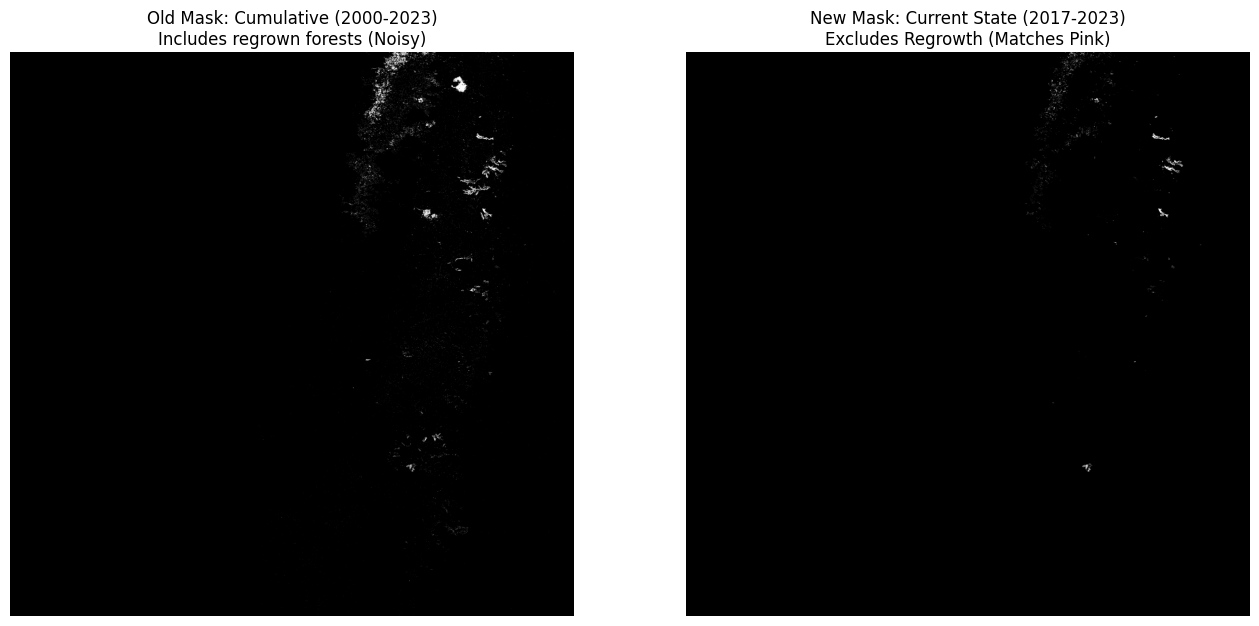

In [ ]:

OLDEST_LOSS_YEAR = 17 

print("Generating 'Current State' Mask (Pink-Aligned)...")



with rasterio.open(gain_path) as src:
    # Downsample to match 'lossyear_small'
    new_h, new_w = lossyear_small.shape
    gain_small = src.read(
        1, 
        out_shape=(new_h, new_w), 
        resampling=rasterio.enums.Resampling.nearest
    )


mask_current_state = (
    (lossyear_small >= OLDEST_LOSS_YEAR) & 
    (gain_small == 0) & 
    (land_mask_small) & 
    (hotspot_mask_small) 
).astype(np.uint8)

print(f"Original Mask Count: {np.sum(cumulative_loss_small > 0)}")
print(f"New 'Pink' Mask Count: {np.sum(mask_current_state > 0)}")

# 3. Visualize the Improvement
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(cumulative_loss_small, cmap='gray')
ax[0].set_title("Old Mask: Cumulative (2000-2023)\nIncludes regrown forests (Noisy)")
ax[0].axis('off')

ax[1].imshow(mask_current_state, cmap='gray')
ax[1].set_title(f"New Mask: Current State (20{OLDEST_LOSS_YEAR}-2023)\nExcludes Regrowth (Matches Pink)")
ax[1].axis('off')

plt.show()

## Downloading Hansen Last and First Validation tifs 

In [ ]:


granule = "30S_080W"
base_url = "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2024-v1.12/"

files_validation = [
    f"Hansen_GFC-2024-v1.12_first_{granule}.tif", 
    f"Hansen_GFC-2024-v1.12_last_{granule}.tif"   
]

print("Downloading validation imagery (this may take time)...")
for file_name in files_validation:
    url = base_url + file_name
    local_path = os.path.join(output_dir, file_name)

    download_file(url, local_path) 
    

print("Validation data ready.")

100%|██████████| 1.51G/1.51G [01:11<00:00, 21.0MiB/s]
100%|██████████| 1.57G/1.57G [01:10<00:00, 22.4MiB/s]

Validation data ready.


## Validation STEP

In [6]:
first_path = os.path.join(output_dir, f"Hansen_GFC-2024-v1.12_first_{granule}.tif")
last_path = os.path.join(output_dir, f"Hansen_GFC-2024-v1.12_last_{granule}.tif")
mask_output_path = os.path.join(output_dir, f"{granule}_filtered_segmentation_mask_hard_2.tif")


In [ ]:
first_path = os.path.join(output_dir, f"Hansen_GFC-2024-v1.12_first_{granule}.tif")
last_path = os.path.join(output_dir, f"Hansen_GFC-2024-v1.12_last_{granule}.tif")
mask_output_path = os.path.join(output_dir, f"{granule}_filtered_segmentation_mask_hard_2.tif")

def normalize(array):
    """Normalize bands to 0-1 for plotting"""
    array_min, array_max = 0, 150 

    return np.clip((array - array_min) / (array_max - array_min), 0, 1)

def plot_validation_chip(center_lat, center_lon, zoom_pixels=250):
    """
    Extracts a small chip from all datasets to validate visually.
    center_lat, center_lon: Geographic coordinates of the spot to check.
    zoom_pixels: Size of the window (e.g., 200x200 pixels).
    """
    
    with rasterio.open(lossyear_path) as src:
        py, px = src.index(center_lon, center_lat)
        window = rasterio.windows.Window(px - zoom_pixels//2, py - zoom_pixels//2, zoom_pixels, zoom_pixels)
    
    with rasterio.open(first_path) as src:

        b_swir = src.read(3, window=window)
        b_nir  = src.read(2, window=window)
        b_red  = src.read(1, window=window)
        img_2000 = np.dstack((normalize(b_swir), normalize(b_nir), normalize(b_red)))


    with rasterio.open(last_path) as src:
        b_swir = src.read(3, window=window)
        b_nir  = src.read(2, window=window)
        b_red  = src.read(1, window=window)
        img_2023 = np.dstack((normalize(b_swir), normalize(b_nir), normalize(b_red)))


    with rasterio.open(mask_output_path) as src:
        mask_chip = src.read(1, window=window)


    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Year 2000
    ax[0].imshow(img_2000)
    ax[0].set_title("Year 2000 (Baseline)\n(Green=Forest)", fontsize=14)
    ax[0].axis('off')
    
    # Year 2023
    ax[1].imshow(img_2023)
    ax[1].set_title("Year 2023 (Current)\n(Pink=Deforestation)", fontsize=14)
    ax[1].axis('off')
    
    # Your Mask
    # Overlay mask on top of 2023 image for clarity
    ax[2].imshow(img_2023, alpha=0.5) 
    ax[2].imshow(mask_chip, cmap='jet', alpha=0.6, interpolation='nearest') 
    ax[2].set_title("Your Generated Mask\n(Overlaid)", fontsize=14)
    ax[2].axis('off')
    
    plt.suptitle(f"Validation Chip at {center_lat}°S, {center_lon}°W", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


lat_target = -40.86 #-41.3#-40.6
#-40.6#-40.85
lon_target = -72.71#-72.6#-72
##-72#-73.65

try:
    plot_validation_chip(lat_target, lon_target)
except Exception as e:
    print(f"Error: {e}")
    print("Ensure you downloaded the 'first' and 'last' files and the coordinates are inside the granule!")

Error: ./data/chile_gfc_data/40S_080W_filtered_segmentation_mask_hard_2.tif: No such file or directory
Ensure you downloaded the 'first' and 'last' files and the coordinates are inside the granule!


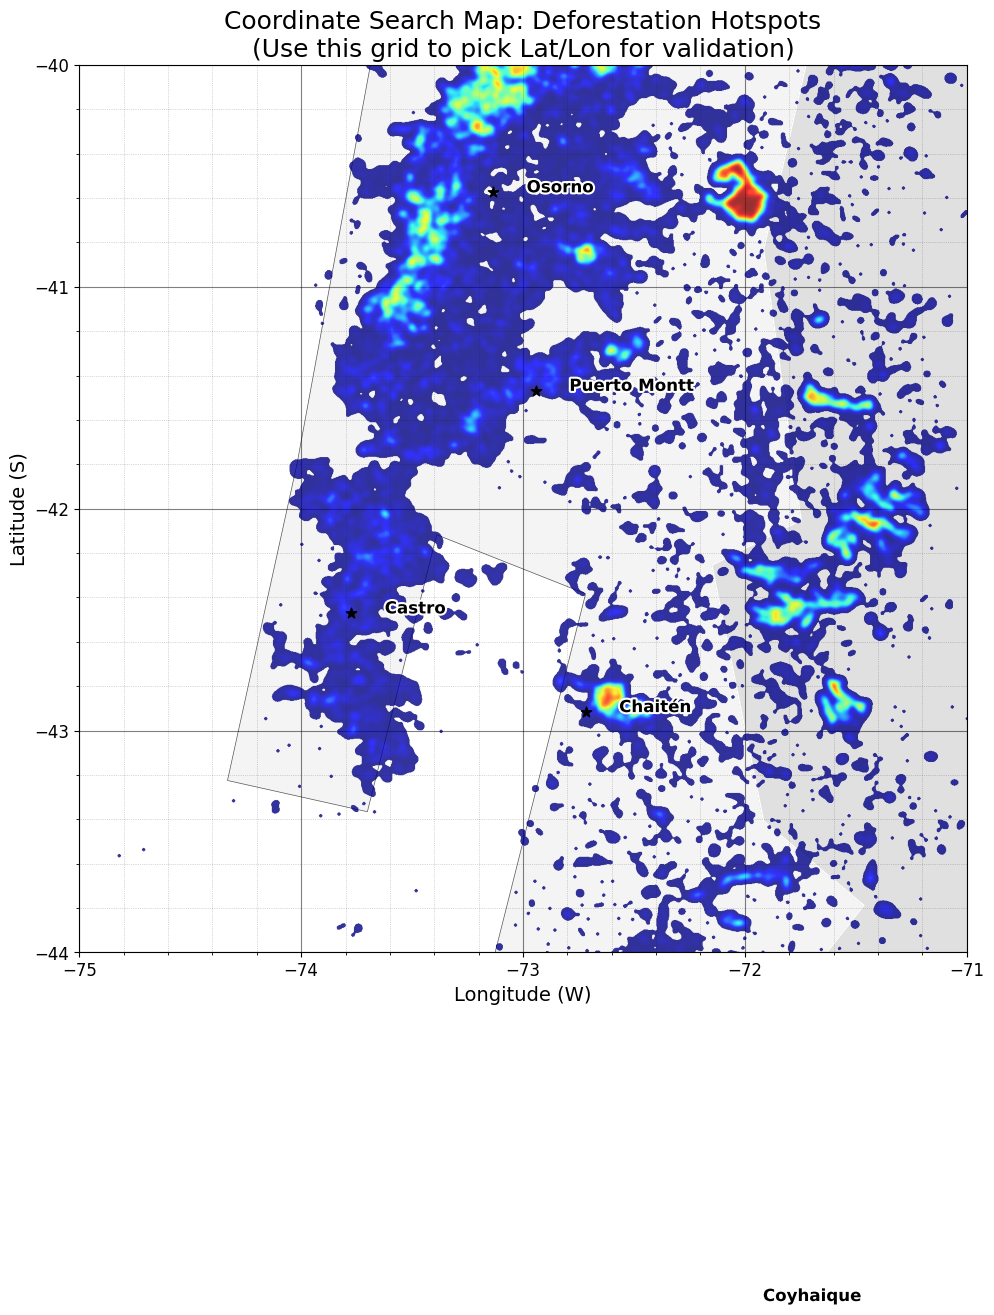

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import geopandas as gpd
from shapely.geometry import box
import matplotlib.ticker as mticker


world_url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json"
world = gpd.read_file(world_url)
chile = world[world.name == "Chile"]


cities_data = {
    'City': ['Valdivia', 'Osorno', 'Puerto Montt', 'Castro', 'Chaitén', 'Coyhaique'],
    'Lat': [-39.8196, -40.5739, -41.4689, -42.4721, -42.9167, -45.5712],
    'Lon': [-73.2452, -73.1335, -72.9411, -73.7732, -72.7167, -72.0685]
}
cities_df = gpd.GeoDataFrame(
    cities_data, 
    geometry=gpd.points_from_xy(cities_data['Lon'], cities_data['Lat'])
)

heatmap_overlay = np.ma.masked_where(loss_density_heatmap < 0.005, loss_density_heatmap)
granule_extent = [-80, -70, -50, -40] # [min_lon, max_lon, min_lat, max_lat]


fig, ax = plt.subplots(figsize=(14, 14)) 


chile.plot(ax=ax, color='#f4f4f4', edgecolor='#555555', linewidth=0.5, zorder=1)
world[world.name == "Argentina"].plot(ax=ax, color='#e0e0e0', edgecolor='white', zorder=1)

cmap_heat = plt.cm.jet
cmap_heat.set_bad('white', alpha=0)
ax.imshow(
    heatmap_overlay, 
    cmap=cmap_heat, 
    extent=granule_extent, 
    origin='upper', 
    alpha=0.8, 
    zorder=2
)

cities_df.plot(ax=ax, color='black', markersize=60, marker='*', zorder=5)
for x, y, label in zip(cities_data['Lon'], cities_data['Lat'], cities_data['City']):
    if -50 <= y <= -40: 
        ax.text(x + 0.15, y, label, fontsize=12, color='black', weight='bold', zorder=6,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")])


ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mticker.MultipleLocator(1))


ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.2))

ax.grid(which='major', color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax.grid(which='minor', color='black', linestyle=':', linewidth=0.5, alpha=0.3)

ax.set_title("Coordinate Search Map: Deforestation Hotspots\n(Use this grid to pick Lat/Lon for validation)", fontsize=18)
ax.set_xlim(-75, -71)
ax.set_ylim(-44, -40)
ax.set_xlabel("Longitude (W)", fontsize=14)
ax.set_ylabel("Latitude (S)", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

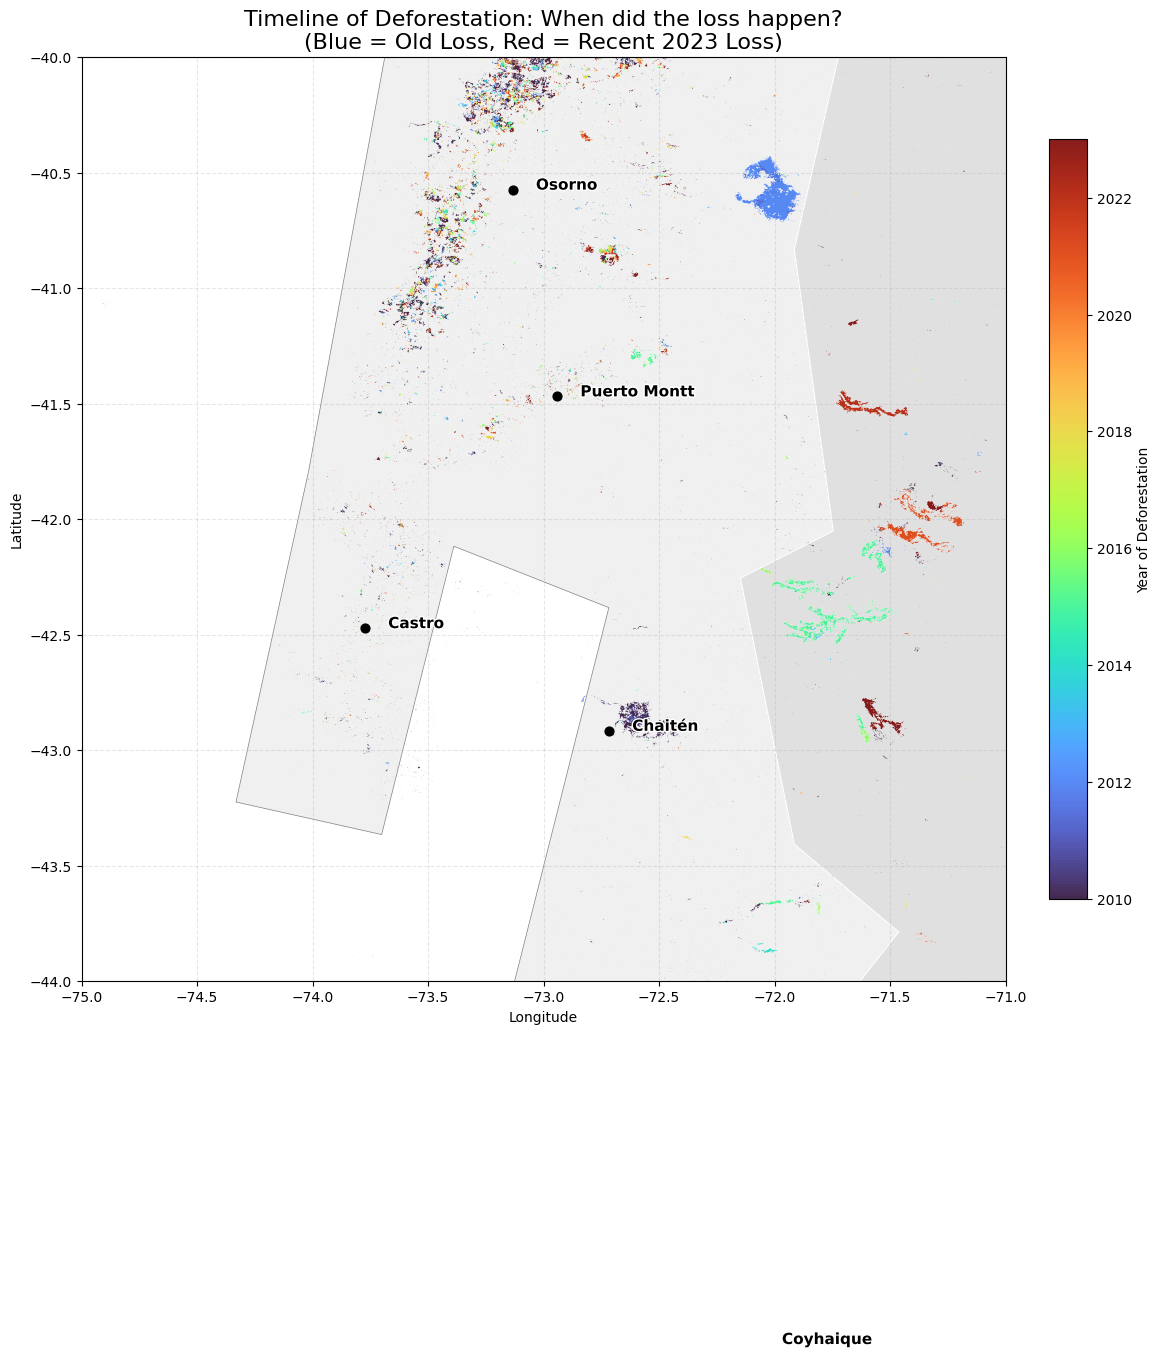

In [ ]:

loss_years_data = np.ma.masked_where(lossyear_small == 0, np.int32(lossyear_small) + 2000)
cmap_time = plt.cm.turbo 
cmap_time.set_bad('white', alpha=0) 

granule_extent = [-80, -70, -50, -40]
world_url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json"
world = gpd.read_file(world_url)
chile = world[world.name == "Chile"]
fig, ax = plt.subplots(figsize=(14, 12))


chile.plot(ax=ax, color='#f0f0f0', edgecolor='grey', linewidth=0.5, zorder=1)
world[world.name == "Argentina"].plot(ax=ax, color='#e0e0e0', edgecolor='white', zorder=1)


im = ax.imshow(
    loss_years_data, 
    cmap=cmap_time, 
    extent=granule_extent, 
    origin='upper', 
    vmin=2010, 
    vmax=2023,
    alpha=0.9, 
    zorder=2
)


cities_data = {
    'City': ['Valdivia', 'Osorno', 'Puerto Montt', 'Castro', 'Chaitén', 'Coyhaique'],
    'Lat': [-39.8196, -40.5739, -41.4689, -42.4721, -42.9167, -45.5712],
    'Lon': [-73.2452, -73.1335, -72.9411, -73.7732, -72.7167, -72.0685]
}
cities_df = gpd.GeoDataFrame(
    cities_data, 
    geometry=gpd.points_from_xy(cities_data['Lon'], cities_data['Lat'])
)

cities_df.plot(ax=ax, color='black', markersize=40, zorder=3)
for x, y, label in zip(cities_data['Lon'], cities_data['Lat'], cities_data['City']):
    if -50 <= y <= -40:
        ax.text(x + 0.1, y, label, fontsize=11, color='black', weight='bold', zorder=4, 
                path_effects=[pe.withStroke(linewidth=2, foreground="white")])

# D. Formatting
ax.set_title("Timeline of Deforestation: When did the loss happen?\n(Blue = Old Loss, Red = Recent 2023 Loss)", fontsize=16)
ax.set_xlim(-75, -71)
ax.set_ylim(-44, -40)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle='--', alpha=0.3)

# E. Colorbar with Year Labels
cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
cbar.set_label("Year of Deforestation")
cbar.set_ticks(np.arange(2010, 2024, 2)) # Label every 2 years

plt.show()